<div style="text-align: center; font-size: 30pt; font-weight: bold; margin: 1em 0em 1em 0em">Homework 4: Kaggle competition</div>

In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import umap

from skimage.transform import resize
from ripser import ripser, plot_dgms, lower_star_img
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

# Import Datasets

In [57]:
images_train = np.load('train_images.npy', encoding='latin1')
labels_train = pd.read_csv('train_labels.csv')
y_train_labels = np.array(labels_train)[:, 1]

# Union find structure

credits: http://code.activestate.com/recipes/215912-union-find-data-structure/

In [3]:
class UnionFind:
    
    def __init__(self):
        '''\
Create an empty union find data structure.'''
        self.num_weights = {}
        self.parent_pointers = {}
        self.num_to_objects = {}
        self.objects_to_num = {}
        self.__repr__ = self.__str__
        
    def insert_objects(self, objects):
        '''\
Insert a sequence of objects into the structure.  All must be Python hashable.'''
        for object in objects:
            self.find(object);
            
    def find(self, object):
        '''\
Find the root of the set that an object is in.
If the object was not known, will make it known, and it becomes its own set.
Object must be Python hashable.'''
        if not object in self.objects_to_num:
            obj_num = len(self.objects_to_num)
            self.num_weights[obj_num] = 1
            self.objects_to_num[object] = obj_num
            self.num_to_objects[obj_num] = object
            self.parent_pointers[obj_num] = obj_num
            return object
        stk = [self.objects_to_num[object]]
        par = self.parent_pointers[stk[-1]]
        while par != stk[-1]:
            stk.append(par)
            par = self.parent_pointers[par]
        for i in stk:
            self.parent_pointers[i] = par
        return self.num_to_objects[par]
    
    def union(self, object1, object2):
        '''\
Combine the sets that contain the two objects given.
Both objects must be Python hashable.
If either or both objects are unknown, will make them known, and combine them.'''
        o1p = self.find(object1)
        o2p = self.find(object2)
        if o1p != o2p:
            on1 = self.objects_to_num[o1p]
            on2 = self.objects_to_num[o2p]
            w1 = self.num_weights[on1]
            w2 = self.num_weights[on2]
            if w1 < w2:
                o1p, o2p, on1, on2, w1, w2 = o2p, o1p, on2, on1, w2, w1
            self.num_weights[on1] = w1+w2
            del self.num_weights[on2]
            self.parent_pointers[on2] = on1

# Preprocessing part:

## Find connex components of the image thanks to the union find structure

In [4]:
def find_connex_components(image, seuil):
    
    sets_of_connex_pixels = UnionFind()

    for i in range(100):
    
        for j in range(100):
        
            if image[i][j] > seuil:
            
                # We create the list of coordinate that are in the neighborhood of (i,j) depending
                # on wheter we are at one edge or corner of the image or not
            
                not_neighbors_of_ij = []
            
                # As we are scanning the image from top to bottom, from left to right, we can limit the neighborhood
            
                neighbors_possible = [(i-1, j), (i-1, j-1), (i-1, j+1), (i, j-1), (i, j+1), (i+1, j-1), (i+1, j), (i+1, j+1)]

                for neighbors in neighbors_possible:
                
                    # Patch the fact that "array[-1]" doesn't return an error
                
                    if neighbors[0] >= 0 and neighbors[1] >= 0:
                
                        try:
                    
                            # if this returns an error, it means that we are in a "special case" (i.e edge or corner)
                    
                            image[neighbors[0]][neighbors[1]]
                    
                        except:
                    
                            # Thus, it's not in the neighborhood
                    
                            not_neighbors_of_ij.append(neighbors)
                
                    else: 

                        not_neighbors_of_ij.append(neighbors)
 
                has_a_neighbor = 0
            
                for neighbors in neighbors_possible:
                
                    if neighbors not in not_neighbors_of_ij:
                
                        if image[neighbors[0]][neighbors[1]] > seuil:
                        
                            sets_of_connex_pixels.union((i,j), neighbors)
                            has_a_neighbor = 1
            
                if has_a_neighbor == 0:
                
                    sets_of_connex_pixels.find((i,j))
    
    return(sets_of_connex_pixels)

## Create a list of the lists of coordinates that are in a connex ensemble

In [5]:
def create_lists_of_connex_coordinates(image, seuil):
    
    sets_of_connex_pixels = find_connex_components(image, seuil)

    dict_of_parents = sets_of_connex_pixels.parent_pointers
    id_to_coordinate = sets_of_connex_pixels.num_to_objects
    dict_of_sets = dict()
    list_of_connex_id = []

    for children, parents in dict_of_parents.items():
    
        if parents not in dict_of_sets:
        
            dict_of_sets[parents] = []
            dict_of_sets[parents].append(children)
    
        else:
        
            dict_of_sets[parents].append(children)

    for connex_elements, connex_ids in dict_of_sets.items():
    
        list_of_connex_coordinates = []
    
        for ids in connex_ids:
        
            list_of_connex_coordinates.append(id_to_coordinate[ids])
    
        list_of_connex_id.append(list_of_connex_coordinates)
    
    return(list_of_connex_id)

## Find the connex set of maximum area

In [6]:
def find_max_area_connex_set(image, seuil):
    
    list_of_connex_id = create_lists_of_connex_coordinates(image, seuil)
    max_area = 0
    connex_set_of_max_area = []

    for connex_sets in list_of_connex_id:
    
        min_i = math.inf
        max_i = 0
        min_j = math.inf
        max_j = 0
    
        for (i,j) in connex_sets:
        
            if i < min_i:
            
                min_i = i
        
            if i > max_i:
            
                max_i = i
        
            if j < min_j:
            
                min_j = j
        
            if j > max_j:
            
                max_j = j
    
        area = (max_i - min_i)*(max_j - min_j)
    
        if area > max_area:
        
            max_area = area
            connex_set_of_max_area = connex_sets
            max_i_object, min_i_object, max_j_object, min_j_object = max_i, min_i, max_j, min_j
    
    return(connex_set_of_max_area, [max_area, max_i_object, min_i_object, max_j_object, min_j_object])

## Denoise the data but keep the original size

In [7]:
def denoise_data(data, seuil):
    
    data_denoised = []
    data_max_coordinates = []
    
    for k in tqdm(range(len(data))):
        
        data_k = [k]
        image = data[k][1].reshape((100,100))
        image_denoised = np.zeros((100,100))
        connex_set_of_max_area, max_coordinates = find_max_area_connex_set(image, seuil)
        data_max_coordinates.append(max_coordinates)

        for (i,j) in connex_set_of_max_area:
    
            image_denoised[i][j] = image[i][j]
        
        data_k.append(image_denoised)
        data_denoised.append(data_k)
    
    return(data_denoised, data_max_coordinates)

## Crop, center and resize the image to size = (image_size, image_size)

In [136]:
def crop_and_center_data(data_denoised, data_denoised_coordinates, image_size):
    
    data_centered = []
    max_i, min_i, max_j, min_j = np.array(data_denoised_coordinates)[:,1], np.array(data_denoised_coordinates)[:,2], np.array(data_denoised_coordinates)[:,3], np.array(data_denoised_coordinates)[:,4]
    elongation_i = max_i - min_i
    elongation_j = max_j - min_j
    max_elongation = np.max((elongation_i, elongation_j), axis=0)
    start_i = (max_elongation - elongation_i)/2
    start_j = (max_elongation - elongation_j)/2
    
    for k in tqdm(range(len(data_denoised))):
        
        data_k = [k]
        image_centered = np.zeros((max_elongation[k]+1, max_elongation[k]+1))
        image_big = data_denoised[k][1]
        
        for i in range(elongation_i[k]+1):
            
            for j in range(elongation_j[k]+1):
                
                image_centered[int(start_i[k])+i, int(start_j[k])+j] = image_big[min_i[k]+i][min_j[k]+j]
        
        image_reshaped = resize(image=image_centered, output_shape=(image_size,image_size))
        data_k.append(image_reshaped)
        data_centered.append(data_k)
    
    return(data_centered)

## Augment the contrast of the image

In [18]:
def augment_contrast(data_centered, seuil_contrast):

    data_contrast = []
    
    for k in tqdm(range(len(data_centered))):
        
        data_k = [k]
        image_bis = np.zeros(np.shape(data_centered[k][1]))

        for i in range(np.shape(data_centered[k][1])[0]):
    
            for j in range(np.shape(data_centered[k][1])[1]):
        
                if data_centered[k][1][i,j] > seuil_contrast:
            
                    image_bis[i,j] = data_centered[k][1][i,j]
        
        data_k.append(image_bis)
        data_contrast.append(data_k)
    
    return(data_contrast)

## Remove the pixels that are "alone"

In [19]:
def remove_alone_pixels(data):
    
    for k in tqdm(range(len(data))):
        
        image = data[k][1]
    
        for i in range(image.shape[0]):
    
            for j in range(image.shape[1]):
        
                if image[i][j] > 0:
            
                    # We create the list of coordinate that are in the neighborhood of (i,j) depending
                    # on wheter we are at one edge or corner of the image or not
            
                    not_neighbors_of_ij = []
            
                    # As we are scanning the image from top to bottom, from left to right, we can limit the neighborhood
            
                    neighbors_possible = [(i-1, j), (i-1, j-1), (i-1, j+1), (i, j-1), (i, j+1), (i+1, j-1), (i+1, j), (i+1, j+1)]

                    for neighbors in neighbors_possible:
                
                        # Patch the fact that "array[-1]" doesn't return an error
                
                        if neighbors[0] >= 0 and neighbors[1] >= 0:
                
                            try:
                    
                                # if this returns an error, it means that we are in a "special case" (i.e edge or corner)
                    
                                image[neighbors[0]][neighbors[1]]
                    
                            except:
                    
                                # Thus, it's not in the neighborhood
                    
                                not_neighbors_of_ij.append(neighbors)
                
                        else: 

                            not_neighbors_of_ij.append(neighbors)
                    
                    has_neighbors = False
                            
                    for neighbors in neighbors_possible:
                        
                        if neighbors not in not_neighbors_of_ij:
                            
                            if image[neighbors[0]][neighbors[1]] > 0:
                                
                                has_neighbors = True
                    
                    if not has_neighbors:
                        
                        image[i][j] = 0

In [30]:
data_denoised, data_denoised_coordinates = denoise_data(images_train, 90)

100%|██████████| 10000/10000 [03:56<00:00, 42.35it/s]


In [137]:
data_centered = crop_and_center_data(data_denoised, data_denoised_coordinates, image_size = 28)

  0%|          | 0/10000 [00:00<?, ?it/s]L:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 10000/10000 [00:12<00:00, 810.00it/s]


In [129]:
data_contrasted = augment_contrast(data_centered, 100)
remove_alone_pixels(data_contrasted)

100%|██████████| 10000/10000 [00:17<00:00, 583.35it/s]


# Data visualization

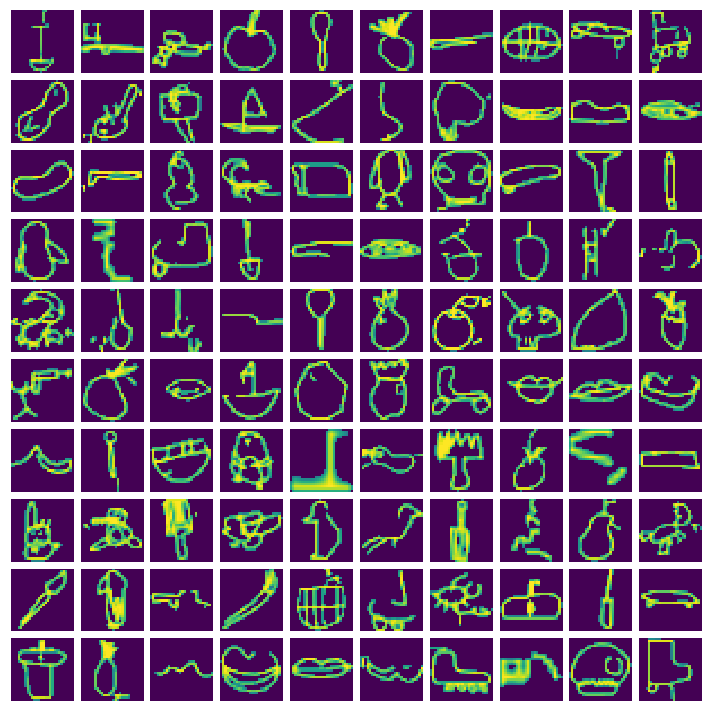

In [130]:
figure = plt.figure(figsize=(10,10))
ax_array = figure.subplots(10, 10)
axes = ax_array.flatten()

for i, ax in enumerate(axes):
    
    ax.imshow(data_contrasted[i][1])
    
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.001, w_pad=0.001)

# Premiers resultats sans plus de travail

### Processing des données pour qu'elles se présentent dans un format utilisable par les algos

**Note**: création du vector 'y_bruit' qui est extrait de y, créé spécialement pour la tâche de différencier les images où il y a un dessin de celles "vides"

In [171]:
data_processed = []
y_processed = []
y_bruit = []
dict_of_labels = dict()
cpt = 0

for k in range(len(data_contrasted)):
    
    data_processed.append(data_contrasted[k][1].flatten())
    labels = y_train_labels[k]
    
    if labels not in dict_of_labels:
        
        dict_of_labels[labels] = cpt
        cpt += 1
    
    y_bruit.append(1*(labels=='empty'))
    y_processed.append(dict_of_labels[labels])

In [216]:
X_train, X_test, y_train, y_test = train_test_split(data_processed, y_processed, test_size=0.3, random_state=42)

### Test de différents modèles

In [81]:
%%time

clf_mlp = MLPClassifier(alpha=0.01, hidden_layer_sizes=(784,90), random_state=0)
clf_mlp.fit(X_train, y_train)
y_pred_mlp = clf_mlp.predict(X_test)
acc_mlp = accuracy_score(y_test, y_pred_mlp)
print ('mlp accuracy: ',acc_mlp)

mlp accuracy:  0.3943333333333333
Wall time: 2min 48s


In [105]:
%%time 

clf_knn = KNeighborsClassifier(n_jobs=-1)
clf_knn.fit(X_train, y_train)
y_pred_knn = clf_knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
print ('KNN accuracy: ',acc_knn)

KNN accuracy:  0.43366666666666664
Wall time: 6.04 s


In [189]:
%%time

clf_gb = GradientBoostingClassifier(n_estimators=100)
clf_gb.fit(X_train, y_train)
y_pred_gb = clf_gb.predict(X_test)
acc_gb = accuracy_score(y_test, y_pred_gb)
print ('Gradient Boosting accuracy: ',acc_gb)

Gradient Boosting accuracy:  0.42433333333333334
Wall time: 14min 39s


In [217]:
%%time

clf_rf = RandomForestClassifier(n_estimators=1500, n_jobs=-1, random_state=0)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print ('random forest accuracy: ',acc_rf)

random forest accuracy:  0.5026666666666667
Wall time: 26.3 s


In [88]:
%%time

clf_svc = SVC(gamma=2, C=1)
clf_svc.fit(X_train, y_train)
y_pred_svc = clf_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_svc)
print ('SVC accuracy: ',acc_rf)

SVC accuracy:  0.47633333333333333
Wall time: 1min 48s


**Tests sur la seule tâche de différencier bruit et image:**

In [172]:
X_train_bruit, X_test_bruit, y_train_bruit, y_test_bruit = train_test_split(data_processed, y_bruit, test_size=0.3, random_state=42)

In [173]:
%%time

clf_rf = RandomForestClassifier(n_estimators=1500, n_jobs=-1, random_state=0)
clf_rf.fit(X_train_bruit, y_train_bruit)
y_pred_rf = clf_rf.predict(X_test_bruit)
acc_rf = accuracy_score(y_test_bruit, y_pred_rf)
print ('random forest accuracy: ',acc_rf)

random forest accuracy:  0.9696666666666667
Wall time: 25.3 s


In [174]:
%%time 

clf_knn = KNeighborsClassifier(n_jobs=-1)
clf_knn.fit(X_train_bruit, y_train_bruit)
y_pred_knn = clf_knn.predict(X_test_bruit)
acc_knn = accuracy_score(y_test_bruit, y_pred_knn)
print ('KNN accuracy: ',acc_knn)

KNN accuracy:  0.9696666666666667
Wall time: 6.03 s


### Implementation de 2 CNN simples

In [99]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

Using TensorFlow backend.


In [106]:
y_train_cnn = np_utils.to_categorical(y_train)
y_test_cnn = np_utils.to_categorical(y_test)
num_classes = y_test_cnn.shape[1]

In [110]:
X_train_cnn = np.array(X_train).reshape(np.array(X_train).shape[0], 1, 28, 28).astype('float32')
X_test_cnn = np.array(X_test).reshape(np.array(X_test).shape[0], 1, 28, 28).astype('float32')

In [119]:
def cnn_model1():
    
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return(model)

In [120]:
def cnn_model2():
    
    input_shape = (1, 28, 28)
    model = Sequential()

    model.add(Conv2D(6, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding="same"))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3), border_mode='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    return model

In [118]:
%%time

# build the model
model = cnn_model2()
# Fit the model
model.fit(X_train_cnn, y_train_cnn, validation_data=(X_test_cnn, y_test_cnn), epochs=100, batch_size=128)
# Final evaluation of the model
scores = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print('Final CNN accuracy: ', scores[1])

L:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same")`
  # This is added back by InteractiveShellApp.init_path()


Train on 7000 samples, validate on 3000 samples
Epoch 1/100
7000/7000 [==============================] - ETA: 45s - loss: 14.7871 - acc: 0.039 - ETA: 33s - loss: 15.1543 - acc: 0.035 - ETA: 28s - loss: 15.2237 - acc: 0.039 - ETA: 26s - loss: 15.3843 - acc: 0.033 - ETA: 24s - loss: 15.3296 - acc: 0.039 - ETA: 23s - loss: 15.2721 - acc: 0.044 - ETA: 22s - loss: 15.2851 - acc: 0.044 - ETA: 21s - loss: 15.2790 - acc: 0.045 - ETA: 20s - loss: 15.2213 - acc: 0.049 - ETA: 19s - loss: 15.2133 - acc: 0.050 - ETA: 18s - loss: 15.2612 - acc: 0.047 - ETA: 18s - loss: 15.2487 - acc: 0.048 - ETA: 17s - loss: 15.2768 - acc: 0.047 - ETA: 17s - loss: 15.3009 - acc: 0.046 - ETA: 16s - loss: 15.3134 - acc: 0.045 - ETA: 16s - loss: 15.2929 - acc: 0.047 - ETA: 15s - loss: 15.3266 - acc: 0.045 - ETA: 15s - loss: 15.3286 - acc: 0.045 - ETA: 14s - loss: 15.3304 - acc: 0.045 - ETA: 14s - loss: 15.3446 - acc: 0.044 - ETA: 13s - loss: 15.3155 - acc: 0.046 - ETA: 13s - loss: 15.3062 - acc: 0.047 - ETA: 12s - loss

7000/7000 [==============================] - ETA: 20s - loss: 14.4811 - acc: 0.101 - ETA: 20s - loss: 14.6311 - acc: 0.089 - ETA: 19s - loss: 14.7070 - acc: 0.085 - ETA: 19s - loss: 14.8079 - acc: 0.080 - ETA: 19s - loss: 14.7929 - acc: 0.081 - ETA: 19s - loss: 14.8459 - acc: 0.078 - ETA: 18s - loss: 14.8298 - acc: 0.079 - ETA: 18s - loss: 14.9121 - acc: 0.074 - ETA: 17s - loss: 14.9622 - acc: 0.071 - ETA: 17s - loss: 14.9919 - acc: 0.068 - ETA: 17s - loss: 14.8997 - acc: 0.074 - ETA: 16s - loss: 14.8438 - acc: 0.078 - ETA: 16s - loss: 14.8643 - acc: 0.076 - ETA: 15s - loss: 14.8550 - acc: 0.077 - ETA: 15s - loss: 14.8888 - acc: 0.075 - ETA: 15s - loss: 14.8633 - acc: 0.077 - ETA: 14s - loss: 14.8260 - acc: 0.079 - ETA: 14s - loss: 14.8288 - acc: 0.079 - ETA: 13s - loss: 14.7840 - acc: 0.081 - ETA: 13s - loss: 14.7725 - acc: 0.082 - ETA: 13s - loss: 14.7826 - acc: 0.081 - ETA: 12s - loss: 14.7689 - acc: 0.082 - ETA: 12s - loss: 14.7673 - acc: 0.082 - ETA: 12s - loss: 14.7554 - acc: 0.0

7000/7000 [==============================] - ETA: 19s - loss: 14.4115 - acc: 0.101 - ETA: 20s - loss: 14.0210 - acc: 0.121 - ETA: 20s - loss: 14.2046 - acc: 0.112 - ETA: 20s - loss: 14.3123 - acc: 0.105 - ETA: 19s - loss: 14.2432 - acc: 0.109 - ETA: 19s - loss: 14.2949 - acc: 0.104 - ETA: 18s - loss: 14.2397 - acc: 0.107 - ETA: 18s - loss: 14.2093 - acc: 0.109 - ETA: 18s - loss: 14.1867 - acc: 0.111 - ETA: 18s - loss: 14.1723 - acc: 0.111 - ETA: 17s - loss: 14.0976 - acc: 0.117 - ETA: 17s - loss: 14.1028 - acc: 0.117 - ETA: 16s - loss: 14.0932 - acc: 0.117 - ETA: 16s - loss: 14.0670 - acc: 0.120 - ETA: 16s - loss: 14.0982 - acc: 0.118 - ETA: 15s - loss: 14.1141 - acc: 0.117 - ETA: 15s - loss: 14.1654 - acc: 0.114 - ETA: 14s - loss: 14.2309 - acc: 0.111 - ETA: 14s - loss: 14.2275 - acc: 0.111 - ETA: 14s - loss: 14.2393 - acc: 0.109 - ETA: 13s - loss: 14.2003 - acc: 0.112 - ETA: 13s - loss: 14.2227 - acc: 0.110 - ETA: 12s - loss: 14.1954 - acc: 0.111 - ETA: 12s - loss: 14.1716 - acc: 0.1

7000/7000 [==============================] - ETA: 21s - loss: 2.0137 - acc: 0.43 - ETA: 21s - loss: 1.8622 - acc: 0.48 - ETA: 20s - loss: 1.8719 - acc: 0.47 - ETA: 20s - loss: 1.8215 - acc: 0.48 - ETA: 20s - loss: 1.8509 - acc: 0.47 - ETA: 19s - loss: 1.8749 - acc: 0.46 - ETA: 19s - loss: 1.8521 - acc: 0.46 - ETA: 18s - loss: 1.8903 - acc: 0.45 - ETA: 18s - loss: 1.8894 - acc: 0.45 - ETA: 18s - loss: 1.8998 - acc: 0.45 - ETA: 17s - loss: 1.9087 - acc: 0.45 - ETA: 17s - loss: 1.9155 - acc: 0.45 - ETA: 17s - loss: 1.9237 - acc: 0.45 - ETA: 16s - loss: 1.9219 - acc: 0.45 - ETA: 16s - loss: 1.9171 - acc: 0.45 - ETA: 15s - loss: 1.9373 - acc: 0.45 - ETA: 15s - loss: 1.9323 - acc: 0.45 - ETA: 15s - loss: 1.9369 - acc: 0.45 - ETA: 14s - loss: 1.9300 - acc: 0.45 - ETA: 14s - loss: 1.9286 - acc: 0.46 - ETA: 13s - loss: 1.9297 - acc: 0.46 - ETA: 13s - loss: 1.9235 - acc: 0.46 - ETA: 12s - loss: 1.9312 - acc: 0.46 - ETA: 12s - loss: 1.9275 - acc: 0.46 - ETA: 11s - loss: 1.9204 - acc: 0.46 - ETA: 

7000/7000 [==============================] - ETA: 21s - loss: 1.2626 - acc: 0.61 - ETA: 20s - loss: 1.2747 - acc: 0.61 - ETA: 19s - loss: 1.4680 - acc: 0.58 - ETA: 19s - loss: 1.4762 - acc: 0.58 - ETA: 19s - loss: 1.4842 - acc: 0.58 - ETA: 19s - loss: 1.4588 - acc: 0.58 - ETA: 18s - loss: 1.4634 - acc: 0.58 - ETA: 18s - loss: 1.4676 - acc: 0.58 - ETA: 17s - loss: 1.4754 - acc: 0.58 - ETA: 17s - loss: 1.4880 - acc: 0.58 - ETA: 17s - loss: 1.4808 - acc: 0.58 - ETA: 16s - loss: 1.4648 - acc: 0.58 - ETA: 16s - loss: 1.4398 - acc: 0.58 - ETA: 16s - loss: 1.4439 - acc: 0.58 - ETA: 15s - loss: 1.4494 - acc: 0.58 - ETA: 15s - loss: 1.4478 - acc: 0.58 - ETA: 14s - loss: 1.4503 - acc: 0.58 - ETA: 14s - loss: 1.4574 - acc: 0.58 - ETA: 14s - loss: 1.4488 - acc: 0.58 - ETA: 13s - loss: 1.4372 - acc: 0.58 - ETA: 13s - loss: 1.4297 - acc: 0.59 - ETA: 12s - loss: 1.4232 - acc: 0.59 - ETA: 12s - loss: 1.4122 - acc: 0.59 - ETA: 12s - loss: 1.3979 - acc: 0.59 - ETA: 11s - loss: 1.3984 - acc: 0.59 - ETA: 

7000/7000 [==============================] - ETA: 20s - loss: 1.1975 - acc: 0.66 - ETA: 21s - loss: 1.1564 - acc: 0.67 - ETA: 20s - loss: 1.1268 - acc: 0.68 - ETA: 20s - loss: 1.0744 - acc: 0.69 - ETA: 20s - loss: 1.0624 - acc: 0.69 - ETA: 20s - loss: 1.0660 - acc: 0.69 - ETA: 19s - loss: 1.0802 - acc: 0.68 - ETA: 19s - loss: 1.0759 - acc: 0.68 - ETA: 19s - loss: 1.0815 - acc: 0.68 - ETA: 18s - loss: 1.0847 - acc: 0.69 - ETA: 18s - loss: 1.0808 - acc: 0.68 - ETA: 17s - loss: 1.0837 - acc: 0.68 - ETA: 17s - loss: 1.0864 - acc: 0.68 - ETA: 16s - loss: 1.0717 - acc: 0.68 - ETA: 16s - loss: 1.0905 - acc: 0.67 - ETA: 16s - loss: 1.0995 - acc: 0.67 - ETA: 15s - loss: 1.0993 - acc: 0.67 - ETA: 15s - loss: 1.1061 - acc: 0.67 - ETA: 14s - loss: 1.1116 - acc: 0.67 - ETA: 14s - loss: 1.1031 - acc: 0.67 - ETA: 14s - loss: 1.0975 - acc: 0.67 - ETA: 13s - loss: 1.0994 - acc: 0.67 - ETA: 13s - loss: 1.1105 - acc: 0.67 - ETA: 12s - loss: 1.1102 - acc: 0.67 - ETA: 12s - loss: 1.1127 - acc: 0.67 - ETA: 

7000/7000 [==============================] - ETA: 20s - loss: 0.8155 - acc: 0.72 - ETA: 20s - loss: 0.7962 - acc: 0.75 - ETA: 19s - loss: 0.8159 - acc: 0.73 - ETA: 19s - loss: 0.8180 - acc: 0.73 - ETA: 19s - loss: 0.8543 - acc: 0.72 - ETA: 18s - loss: 0.8313 - acc: 0.73 - ETA: 18s - loss: 0.8396 - acc: 0.72 - ETA: 18s - loss: 0.8080 - acc: 0.74 - ETA: 17s - loss: 0.8298 - acc: 0.73 - ETA: 17s - loss: 0.8318 - acc: 0.73 - ETA: 16s - loss: 0.8567 - acc: 0.73 - ETA: 16s - loss: 0.8761 - acc: 0.72 - ETA: 16s - loss: 0.8978 - acc: 0.72 - ETA: 15s - loss: 0.9022 - acc: 0.71 - ETA: 15s - loss: 0.9058 - acc: 0.71 - ETA: 14s - loss: 0.9080 - acc: 0.71 - ETA: 14s - loss: 0.9114 - acc: 0.71 - ETA: 14s - loss: 0.9102 - acc: 0.71 - ETA: 13s - loss: 0.9002 - acc: 0.72 - ETA: 13s - loss: 0.9062 - acc: 0.71 - ETA: 12s - loss: 0.9167 - acc: 0.71 - ETA: 12s - loss: 0.9247 - acc: 0.71 - ETA: 12s - loss: 0.9240 - acc: 0.71 - ETA: 11s - loss: 0.9208 - acc: 0.71 - ETA: 11s - loss: 0.9258 - acc: 0.71 - ETA: 

7000/7000 [==============================] - ETA: 19s - loss: 0.8685 - acc: 0.76 - ETA: 19s - loss: 0.7395 - acc: 0.78 - ETA: 19s - loss: 0.7490 - acc: 0.77 - ETA: 19s - loss: 0.8032 - acc: 0.75 - ETA: 19s - loss: 0.8201 - acc: 0.74 - ETA: 18s - loss: 0.8146 - acc: 0.75 - ETA: 18s - loss: 0.8352 - acc: 0.75 - ETA: 18s - loss: 0.8373 - acc: 0.74 - ETA: 17s - loss: 0.8247 - acc: 0.75 - ETA: 17s - loss: 0.8080 - acc: 0.75 - ETA: 16s - loss: 0.8111 - acc: 0.75 - ETA: 16s - loss: 0.7942 - acc: 0.76 - ETA: 16s - loss: 0.7998 - acc: 0.75 - ETA: 15s - loss: 0.8090 - acc: 0.75 - ETA: 15s - loss: 0.8041 - acc: 0.75 - ETA: 14s - loss: 0.7937 - acc: 0.76 - ETA: 14s - loss: 0.7824 - acc: 0.76 - ETA: 14s - loss: 0.7717 - acc: 0.76 - ETA: 13s - loss: 0.7757 - acc: 0.76 - ETA: 13s - loss: 0.7822 - acc: 0.76 - ETA: 13s - loss: 0.7801 - acc: 0.76 - ETA: 12s - loss: 0.7840 - acc: 0.76 - ETA: 12s - loss: 0.7757 - acc: 0.76 - ETA: 11s - loss: 0.7730 - acc: 0.76 - ETA: 11s - loss: 0.7728 - acc: 0.76 - ETA: 

7000/7000 [==============================] - ETA: 22s - loss: 0.6868 - acc: 0.82 - ETA: 22s - loss: 0.6103 - acc: 0.84 - ETA: 21s - loss: 0.5704 - acc: 0.84 - ETA: 21s - loss: 0.5983 - acc: 0.82 - ETA: 20s - loss: 0.6048 - acc: 0.81 - ETA: 19s - loss: 0.5881 - acc: 0.82 - ETA: 19s - loss: 0.6075 - acc: 0.82 - ETA: 18s - loss: 0.5925 - acc: 0.82 - ETA: 18s - loss: 0.5748 - acc: 0.82 - ETA: 18s - loss: 0.5783 - acc: 0.82 - ETA: 17s - loss: 0.5820 - acc: 0.82 - ETA: 17s - loss: 0.5856 - acc: 0.82 - ETA: 16s - loss: 0.5807 - acc: 0.82 - ETA: 16s - loss: 0.5783 - acc: 0.82 - ETA: 15s - loss: 0.5842 - acc: 0.81 - ETA: 15s - loss: 0.5812 - acc: 0.81 - ETA: 15s - loss: 0.5848 - acc: 0.81 - ETA: 14s - loss: 0.5795 - acc: 0.81 - ETA: 14s - loss: 0.5756 - acc: 0.81 - ETA: 13s - loss: 0.5695 - acc: 0.81 - ETA: 13s - loss: 0.5735 - acc: 0.81 - ETA: 13s - loss: 0.5726 - acc: 0.81 - ETA: 12s - loss: 0.5784 - acc: 0.81 - ETA: 12s - loss: 0.5816 - acc: 0.81 - ETA: 11s - loss: 0.5893 - acc: 0.81 - ETA: 

7000/7000 [==============================] - ETA: 20s - loss: 0.4347 - acc: 0.84 - ETA: 19s - loss: 0.4610 - acc: 0.85 - ETA: 19s - loss: 0.4705 - acc: 0.85 - ETA: 19s - loss: 0.4669 - acc: 0.85 - ETA: 19s - loss: 0.4959 - acc: 0.84 - ETA: 18s - loss: 0.5016 - acc: 0.84 - ETA: 18s - loss: 0.5116 - acc: 0.83 - ETA: 17s - loss: 0.5308 - acc: 0.83 - ETA: 17s - loss: 0.5277 - acc: 0.83 - ETA: 17s - loss: 0.5192 - acc: 0.83 - ETA: 16s - loss: 0.5262 - acc: 0.83 - ETA: 16s - loss: 0.5341 - acc: 0.82 - ETA: 15s - loss: 0.5419 - acc: 0.82 - ETA: 15s - loss: 0.5279 - acc: 0.83 - ETA: 15s - loss: 0.5219 - acc: 0.83 - ETA: 14s - loss: 0.5155 - acc: 0.83 - ETA: 14s - loss: 0.5154 - acc: 0.83 - ETA: 14s - loss: 0.5233 - acc: 0.83 - ETA: 13s - loss: 0.5172 - acc: 0.83 - ETA: 13s - loss: 0.5244 - acc: 0.83 - ETA: 12s - loss: 0.5247 - acc: 0.83 - ETA: 12s - loss: 0.5293 - acc: 0.83 - ETA: 12s - loss: 0.5325 - acc: 0.83 - ETA: 11s - loss: 0.5322 - acc: 0.83 - ETA: 11s - loss: 0.5262 - acc: 0.83 - ETA: 

7000/7000 [==============================] - ETA: 21s - loss: 0.4784 - acc: 0.85 - ETA: 21s - loss: 0.4433 - acc: 0.85 - ETA: 20s - loss: 0.4481 - acc: 0.85 - ETA: 20s - loss: 0.4306 - acc: 0.85 - ETA: 19s - loss: 0.3974 - acc: 0.86 - ETA: 19s - loss: 0.4004 - acc: 0.86 - ETA: 18s - loss: 0.4101 - acc: 0.86 - ETA: 18s - loss: 0.4271 - acc: 0.86 - ETA: 17s - loss: 0.4207 - acc: 0.86 - ETA: 17s - loss: 0.4333 - acc: 0.86 - ETA: 17s - loss: 0.4306 - acc: 0.85 - ETA: 16s - loss: 0.4274 - acc: 0.85 - ETA: 16s - loss: 0.4271 - acc: 0.86 - ETA: 16s - loss: 0.4401 - acc: 0.85 - ETA: 15s - loss: 0.4476 - acc: 0.85 - ETA: 15s - loss: 0.4515 - acc: 0.85 - ETA: 14s - loss: 0.4550 - acc: 0.85 - ETA: 14s - loss: 0.4591 - acc: 0.84 - ETA: 14s - loss: 0.4540 - acc: 0.85 - ETA: 13s - loss: 0.4468 - acc: 0.85 - ETA: 13s - loss: 0.4425 - acc: 0.85 - ETA: 12s - loss: 0.4408 - acc: 0.85 - ETA: 12s - loss: 0.4379 - acc: 0.85 - ETA: 12s - loss: 0.4356 - acc: 0.85 - ETA: 11s - loss: 0.4368 - acc: 0.85 - ETA: 

7000/7000 [==============================] - ETA: 21s - loss: 0.4205 - acc: 0.85 - ETA: 20s - loss: 0.3767 - acc: 0.87 - ETA: 19s - loss: 0.3854 - acc: 0.87 - ETA: 19s - loss: 0.3576 - acc: 0.88 - ETA: 19s - loss: 0.3338 - acc: 0.89 - ETA: 19s - loss: 0.3375 - acc: 0.88 - ETA: 19s - loss: 0.3544 - acc: 0.88 - ETA: 18s - loss: 0.3654 - acc: 0.87 - ETA: 18s - loss: 0.3677 - acc: 0.87 - ETA: 17s - loss: 0.3731 - acc: 0.87 - ETA: 17s - loss: 0.3723 - acc: 0.87 - ETA: 17s - loss: 0.3887 - acc: 0.87 - ETA: 16s - loss: 0.3963 - acc: 0.86 - ETA: 16s - loss: 0.3870 - acc: 0.87 - ETA: 15s - loss: 0.3929 - acc: 0.86 - ETA: 15s - loss: 0.3925 - acc: 0.87 - ETA: 15s - loss: 0.3905 - acc: 0.87 - ETA: 14s - loss: 0.3874 - acc: 0.87 - ETA: 14s - loss: 0.3877 - acc: 0.87 - ETA: 13s - loss: 0.3807 - acc: 0.87 - ETA: 13s - loss: 0.3802 - acc: 0.87 - ETA: 12s - loss: 0.3818 - acc: 0.87 - ETA: 12s - loss: 0.3810 - acc: 0.87 - ETA: 12s - loss: 0.3780 - acc: 0.88 - ETA: 11s - loss: 0.3734 - acc: 0.88 - ETA: 

7000/7000 [==============================] - ETA: 20s - loss: 0.3200 - acc: 0.89 - ETA: 19s - loss: 0.3571 - acc: 0.88 - ETA: 20s - loss: 0.3449 - acc: 0.88 - ETA: 20s - loss: 0.3615 - acc: 0.88 - ETA: 19s - loss: 0.3546 - acc: 0.88 - ETA: 19s - loss: 0.3419 - acc: 0.88 - ETA: 19s - loss: 0.3486 - acc: 0.88 - ETA: 18s - loss: 0.3439 - acc: 0.89 - ETA: 18s - loss: 0.3328 - acc: 0.89 - ETA: 17s - loss: 0.3296 - acc: 0.89 - ETA: 17s - loss: 0.3148 - acc: 0.90 - ETA: 17s - loss: 0.3088 - acc: 0.90 - ETA: 16s - loss: 0.3046 - acc: 0.90 - ETA: 16s - loss: 0.3058 - acc: 0.90 - ETA: 15s - loss: 0.3060 - acc: 0.90 - ETA: 15s - loss: 0.3094 - acc: 0.90 - ETA: 15s - loss: 0.3096 - acc: 0.89 - ETA: 14s - loss: 0.3085 - acc: 0.90 - ETA: 14s - loss: 0.3064 - acc: 0.89 - ETA: 13s - loss: 0.3143 - acc: 0.89 - ETA: 13s - loss: 0.3153 - acc: 0.89 - ETA: 12s - loss: 0.3129 - acc: 0.89 - ETA: 12s - loss: 0.3130 - acc: 0.89 - ETA: 12s - loss: 0.3144 - acc: 0.89 - ETA: 11s - loss: 0.3119 - acc: 0.89 - ETA: 

7000/7000 [==============================] - ETA: 22s - loss: 0.2185 - acc: 0.94 - ETA: 21s - loss: 0.3154 - acc: 0.91 - ETA: 21s - loss: 0.3151 - acc: 0.90 - ETA: 21s - loss: 0.3195 - acc: 0.89 - ETA: 20s - loss: 0.3405 - acc: 0.89 - ETA: 20s - loss: 0.3262 - acc: 0.90 - ETA: 19s - loss: 0.3308 - acc: 0.89 - ETA: 19s - loss: 0.3271 - acc: 0.90 - ETA: 19s - loss: 0.3339 - acc: 0.89 - ETA: 18s - loss: 0.3234 - acc: 0.90 - ETA: 18s - loss: 0.3231 - acc: 0.90 - ETA: 17s - loss: 0.3137 - acc: 0.90 - ETA: 17s - loss: 0.3158 - acc: 0.90 - ETA: 17s - loss: 0.3238 - acc: 0.90 - ETA: 16s - loss: 0.3223 - acc: 0.90 - ETA: 16s - loss: 0.3252 - acc: 0.90 - ETA: 15s - loss: 0.3260 - acc: 0.90 - ETA: 15s - loss: 0.3239 - acc: 0.90 - ETA: 14s - loss: 0.3293 - acc: 0.89 - ETA: 14s - loss: 0.3311 - acc: 0.89 - ETA: 13s - loss: 0.3334 - acc: 0.89 - ETA: 13s - loss: 0.3319 - acc: 0.89 - ETA: 12s - loss: 0.3328 - acc: 0.89 - ETA: 12s - loss: 0.3358 - acc: 0.89 - ETA: 11s - loss: 0.3319 - acc: 0.89 - ETA: 

7000/7000 [==============================] - ETA: 19s - loss: 0.2493 - acc: 0.92 - ETA: 19s - loss: 0.2454 - acc: 0.91 - ETA: 19s - loss: 0.2233 - acc: 0.92 - ETA: 19s - loss: 0.2245 - acc: 0.92 - ETA: 18s - loss: 0.2255 - acc: 0.92 - ETA: 18s - loss: 0.2306 - acc: 0.92 - ETA: 18s - loss: 0.2292 - acc: 0.91 - ETA: 17s - loss: 0.2382 - acc: 0.91 - ETA: 17s - loss: 0.2551 - acc: 0.91 - ETA: 17s - loss: 0.2615 - acc: 0.91 - ETA: 16s - loss: 0.2611 - acc: 0.91 - ETA: 16s - loss: 0.2669 - acc: 0.91 - ETA: 16s - loss: 0.2702 - acc: 0.91 - ETA: 15s - loss: 0.2807 - acc: 0.91 - ETA: 15s - loss: 0.2815 - acc: 0.90 - ETA: 14s - loss: 0.2795 - acc: 0.91 - ETA: 14s - loss: 0.2882 - acc: 0.90 - ETA: 14s - loss: 0.2940 - acc: 0.90 - ETA: 13s - loss: 0.2992 - acc: 0.90 - ETA: 13s - loss: 0.2988 - acc: 0.90 - ETA: 13s - loss: 0.3030 - acc: 0.90 - ETA: 12s - loss: 0.2994 - acc: 0.90 - ETA: 12s - loss: 0.3012 - acc: 0.90 - ETA: 11s - loss: 0.2962 - acc: 0.90 - ETA: 11s - loss: 0.2974 - acc: 0.90 - ETA: 

7000/7000 [==============================] - ETA: 20s - loss: 0.2905 - acc: 0.92 - ETA: 19s - loss: 0.2980 - acc: 0.90 - ETA: 19s - loss: 0.2795 - acc: 0.90 - ETA: 19s - loss: 0.2685 - acc: 0.90 - ETA: 18s - loss: 0.2749 - acc: 0.90 - ETA: 18s - loss: 0.2835 - acc: 0.90 - ETA: 18s - loss: 0.2862 - acc: 0.90 - ETA: 17s - loss: 0.2741 - acc: 0.90 - ETA: 17s - loss: 0.2725 - acc: 0.90 - ETA: 17s - loss: 0.2641 - acc: 0.91 - ETA: 16s - loss: 0.2548 - acc: 0.91 - ETA: 16s - loss: 0.2487 - acc: 0.91 - ETA: 15s - loss: 0.2444 - acc: 0.91 - ETA: 15s - loss: 0.2395 - acc: 0.91 - ETA: 15s - loss: 0.2390 - acc: 0.91 - ETA: 14s - loss: 0.2409 - acc: 0.91 - ETA: 14s - loss: 0.2444 - acc: 0.91 - ETA: 14s - loss: 0.2507 - acc: 0.91 - ETA: 13s - loss: 0.2501 - acc: 0.91 - ETA: 13s - loss: 0.2546 - acc: 0.91 - ETA: 13s - loss: 0.2626 - acc: 0.91 - ETA: 12s - loss: 0.2654 - acc: 0.90 - ETA: 12s - loss: 0.2662 - acc: 0.90 - ETA: 11s - loss: 0.2676 - acc: 0.90 - ETA: 11s - loss: 0.2707 - acc: 0.90 - ETA: 

7000/7000 [==============================] - ETA: 19s - loss: 0.3050 - acc: 0.89 - ETA: 20s - loss: 0.3217 - acc: 0.90 - ETA: 19s - loss: 0.3204 - acc: 0.89 - ETA: 19s - loss: 0.2896 - acc: 0.91 - ETA: 19s - loss: 0.2665 - acc: 0.92 - ETA: 18s - loss: 0.2493 - acc: 0.92 - ETA: 18s - loss: 0.2438 - acc: 0.92 - ETA: 17s - loss: 0.2404 - acc: 0.92 - ETA: 17s - loss: 0.2453 - acc: 0.92 - ETA: 17s - loss: 0.2551 - acc: 0.92 - ETA: 16s - loss: 0.2632 - acc: 0.91 - ETA: 16s - loss: 0.2666 - acc: 0.91 - ETA: 16s - loss: 0.2631 - acc: 0.92 - ETA: 15s - loss: 0.2590 - acc: 0.92 - ETA: 15s - loss: 0.2600 - acc: 0.92 - ETA: 14s - loss: 0.2548 - acc: 0.92 - ETA: 14s - loss: 0.2596 - acc: 0.92 - ETA: 14s - loss: 0.2571 - acc: 0.92 - ETA: 13s - loss: 0.2615 - acc: 0.91 - ETA: 13s - loss: 0.2590 - acc: 0.91 - ETA: 13s - loss: 0.2580 - acc: 0.91 - ETA: 12s - loss: 0.2515 - acc: 0.91 - ETA: 12s - loss: 0.2512 - acc: 0.91 - ETA: 11s - loss: 0.2514 - acc: 0.91 - ETA: 11s - loss: 0.2592 - acc: 0.91 - ETA: 

7000/7000 [==============================] - ETA: 23s - loss: 0.3164 - acc: 0.89 - ETA: 22s - loss: 0.2638 - acc: 0.92 - ETA: 21s - loss: 0.2640 - acc: 0.91 - ETA: 20s - loss: 0.2440 - acc: 0.92 - ETA: 19s - loss: 0.2396 - acc: 0.92 - ETA: 19s - loss: 0.2380 - acc: 0.92 - ETA: 19s - loss: 0.2203 - acc: 0.92 - ETA: 18s - loss: 0.2268 - acc: 0.92 - ETA: 18s - loss: 0.2215 - acc: 0.92 - ETA: 18s - loss: 0.2321 - acc: 0.92 - ETA: 17s - loss: 0.2412 - acc: 0.92 - ETA: 17s - loss: 0.2403 - acc: 0.92 - ETA: 16s - loss: 0.2416 - acc: 0.92 - ETA: 16s - loss: 0.2417 - acc: 0.92 - ETA: 16s - loss: 0.2392 - acc: 0.92 - ETA: 15s - loss: 0.2384 - acc: 0.92 - ETA: 15s - loss: 0.2470 - acc: 0.92 - ETA: 14s - loss: 0.2463 - acc: 0.92 - ETA: 14s - loss: 0.2494 - acc: 0.92 - ETA: 13s - loss: 0.2478 - acc: 0.92 - ETA: 13s - loss: 0.2545 - acc: 0.92 - ETA: 13s - loss: 0.2562 - acc: 0.91 - ETA: 12s - loss: 0.2574 - acc: 0.91 - ETA: 12s - loss: 0.2546 - acc: 0.91 - ETA: 11s - loss: 0.2559 - acc: 0.91 - ETA: 

7000/7000 [==============================] - ETA: 20s - loss: 0.2186 - acc: 0.92 - ETA: 19s - loss: 0.2811 - acc: 0.91 - ETA: 19s - loss: 0.2587 - acc: 0.91 - ETA: 19s - loss: 0.2496 - acc: 0.91 - ETA: 19s - loss: 0.2681 - acc: 0.91 - ETA: 18s - loss: 0.2667 - acc: 0.91 - ETA: 18s - loss: 0.2510 - acc: 0.91 - ETA: 17s - loss: 0.2551 - acc: 0.91 - ETA: 17s - loss: 0.2553 - acc: 0.91 - ETA: 17s - loss: 0.2609 - acc: 0.91 - ETA: 16s - loss: 0.2755 - acc: 0.90 - ETA: 16s - loss: 0.2625 - acc: 0.91 - ETA: 15s - loss: 0.2612 - acc: 0.91 - ETA: 15s - loss: 0.2545 - acc: 0.91 - ETA: 15s - loss: 0.2505 - acc: 0.91 - ETA: 14s - loss: 0.2548 - acc: 0.91 - ETA: 14s - loss: 0.2477 - acc: 0.91 - ETA: 14s - loss: 0.2417 - acc: 0.91 - ETA: 13s - loss: 0.2413 - acc: 0.91 - ETA: 13s - loss: 0.2418 - acc: 0.91 - ETA: 12s - loss: 0.2415 - acc: 0.91 - ETA: 12s - loss: 0.2398 - acc: 0.91 - ETA: 12s - loss: 0.2394 - acc: 0.91 - ETA: 11s - loss: 0.2373 - acc: 0.91 - ETA: 11s - loss: 0.2390 - acc: 0.91 - ETA: 

7000/7000 [==============================] - ETA: 20s - loss: 0.2279 - acc: 0.93 - ETA: 20s - loss: 0.2550 - acc: 0.93 - ETA: 20s - loss: 0.2435 - acc: 0.93 - ETA: 20s - loss: 0.2324 - acc: 0.93 - ETA: 19s - loss: 0.2175 - acc: 0.93 - ETA: 19s - loss: 0.2302 - acc: 0.93 - ETA: 18s - loss: 0.2320 - acc: 0.93 - ETA: 18s - loss: 0.2263 - acc: 0.93 - ETA: 17s - loss: 0.2249 - acc: 0.93 - ETA: 17s - loss: 0.2263 - acc: 0.93 - ETA: 17s - loss: 0.2205 - acc: 0.93 - ETA: 16s - loss: 0.2159 - acc: 0.93 - ETA: 16s - loss: 0.2139 - acc: 0.93 - ETA: 15s - loss: 0.2210 - acc: 0.93 - ETA: 15s - loss: 0.2119 - acc: 0.93 - ETA: 15s - loss: 0.2095 - acc: 0.93 - ETA: 14s - loss: 0.2080 - acc: 0.93 - ETA: 14s - loss: 0.2131 - acc: 0.93 - ETA: 13s - loss: 0.2155 - acc: 0.93 - ETA: 13s - loss: 0.2233 - acc: 0.93 - ETA: 13s - loss: 0.2248 - acc: 0.93 - ETA: 12s - loss: 0.2273 - acc: 0.93 - ETA: 12s - loss: 0.2286 - acc: 0.93 - ETA: 12s - loss: 0.2242 - acc: 0.93 - ETA: 11s - loss: 0.2253 - acc: 0.93 - ETA: 

7000/7000 [==============================] - ETA: 19s - loss: 0.1984 - acc: 0.92 - ETA: 19s - loss: 0.1754 - acc: 0.94 - ETA: 19s - loss: 0.2276 - acc: 0.93 - ETA: 19s - loss: 0.2086 - acc: 0.94 - ETA: 18s - loss: 0.2355 - acc: 0.93 - ETA: 18s - loss: 0.2338 - acc: 0.92 - ETA: 18s - loss: 0.2319 - acc: 0.92 - ETA: 17s - loss: 0.2146 - acc: 0.93 - ETA: 17s - loss: 0.2122 - acc: 0.93 - ETA: 17s - loss: 0.2163 - acc: 0.93 - ETA: 16s - loss: 0.2230 - acc: 0.92 - ETA: 16s - loss: 0.2270 - acc: 0.92 - ETA: 15s - loss: 0.2240 - acc: 0.93 - ETA: 15s - loss: 0.2204 - acc: 0.93 - ETA: 15s - loss: 0.2212 - acc: 0.93 - ETA: 14s - loss: 0.2205 - acc: 0.93 - ETA: 14s - loss: 0.2198 - acc: 0.93 - ETA: 14s - loss: 0.2187 - acc: 0.93 - ETA: 13s - loss: 0.2238 - acc: 0.93 - ETA: 13s - loss: 0.2249 - acc: 0.92 - ETA: 12s - loss: 0.2277 - acc: 0.92 - ETA: 12s - loss: 0.2273 - acc: 0.92 - ETA: 12s - loss: 0.2293 - acc: 0.92 - ETA: 11s - loss: 0.2302 - acc: 0.92 - ETA: 11s - loss: 0.2301 - acc: 0.92 - ETA: 

7000/7000 [==============================] - ETA: 21s - loss: 0.4218 - acc: 0.85 - ETA: 20s - loss: 0.3188 - acc: 0.89 - ETA: 20s - loss: 0.3053 - acc: 0.90 - ETA: 19s - loss: 0.3051 - acc: 0.90 - ETA: 19s - loss: 0.2624 - acc: 0.91 - ETA: 18s - loss: 0.2357 - acc: 0.92 - ETA: 18s - loss: 0.2282 - acc: 0.92 - ETA: 18s - loss: 0.2505 - acc: 0.92 - ETA: 17s - loss: 0.2416 - acc: 0.92 - ETA: 17s - loss: 0.2414 - acc: 0.92 - ETA: 16s - loss: 0.2509 - acc: 0.92 - ETA: 16s - loss: 0.2444 - acc: 0.92 - ETA: 16s - loss: 0.2354 - acc: 0.92 - ETA: 15s - loss: 0.2325 - acc: 0.92 - ETA: 15s - loss: 0.2309 - acc: 0.92 - ETA: 15s - loss: 0.2292 - acc: 0.92 - ETA: 14s - loss: 0.2208 - acc: 0.92 - ETA: 14s - loss: 0.2133 - acc: 0.92 - ETA: 13s - loss: 0.2070 - acc: 0.93 - ETA: 13s - loss: 0.2092 - acc: 0.92 - ETA: 13s - loss: 0.2056 - acc: 0.93 - ETA: 12s - loss: 0.2034 - acc: 0.93 - ETA: 12s - loss: 0.2064 - acc: 0.93 - ETA: 11s - loss: 0.2089 - acc: 0.93 - ETA: 11s - loss: 0.2094 - acc: 0.93 - ETA: 

7000/7000 [==============================] - ETA: 19s - loss: 0.2247 - acc: 0.92 - ETA: 19s - loss: 0.2192 - acc: 0.92 - ETA: 19s - loss: 0.2286 - acc: 0.92 - ETA: 19s - loss: 0.2118 - acc: 0.93 - ETA: 19s - loss: 0.2379 - acc: 0.92 - ETA: 19s - loss: 0.2357 - acc: 0.92 - ETA: 19s - loss: 0.2195 - acc: 0.92 - ETA: 19s - loss: 0.2094 - acc: 0.92 - ETA: 18s - loss: 0.2018 - acc: 0.92 - ETA: 18s - loss: 0.1928 - acc: 0.93 - ETA: 17s - loss: 0.1823 - acc: 0.93 - ETA: 17s - loss: 0.1801 - acc: 0.93 - ETA: 16s - loss: 0.1953 - acc: 0.93 - ETA: 16s - loss: 0.1966 - acc: 0.93 - ETA: 15s - loss: 0.1963 - acc: 0.93 - ETA: 15s - loss: 0.2023 - acc: 0.93 - ETA: 15s - loss: 0.1999 - acc: 0.93 - ETA: 14s - loss: 0.1981 - acc: 0.93 - ETA: 14s - loss: 0.2034 - acc: 0.92 - ETA: 13s - loss: 0.2004 - acc: 0.92 - ETA: 13s - loss: 0.2023 - acc: 0.92 - ETA: 12s - loss: 0.2060 - acc: 0.92 - ETA: 12s - loss: 0.2059 - acc: 0.92 - ETA: 12s - loss: 0.2027 - acc: 0.92 - ETA: 11s - loss: 0.2033 - acc: 0.93 - ETA: 

7000/7000 [==============================] - ETA: 19s - loss: 0.2325 - acc: 0.92 - ETA: 20s - loss: 0.1728 - acc: 0.93 - ETA: 19s - loss: 0.1775 - acc: 0.93 - ETA: 19s - loss: 0.1606 - acc: 0.93 - ETA: 19s - loss: 0.1768 - acc: 0.93 - ETA: 18s - loss: 0.1753 - acc: 0.94 - ETA: 18s - loss: 0.1679 - acc: 0.94 - ETA: 17s - loss: 0.1610 - acc: 0.94 - ETA: 17s - loss: 0.1695 - acc: 0.94 - ETA: 17s - loss: 0.1641 - acc: 0.94 - ETA: 16s - loss: 0.1632 - acc: 0.94 - ETA: 16s - loss: 0.1633 - acc: 0.94 - ETA: 16s - loss: 0.1653 - acc: 0.94 - ETA: 15s - loss: 0.1728 - acc: 0.94 - ETA: 15s - loss: 0.1782 - acc: 0.94 - ETA: 15s - loss: 0.1787 - acc: 0.94 - ETA: 14s - loss: 0.1804 - acc: 0.94 - ETA: 14s - loss: 0.1795 - acc: 0.94 - ETA: 14s - loss: 0.1828 - acc: 0.94 - ETA: 13s - loss: 0.1851 - acc: 0.94 - ETA: 13s - loss: 0.1873 - acc: 0.94 - ETA: 12s - loss: 0.1831 - acc: 0.94 - ETA: 12s - loss: 0.1858 - acc: 0.94 - ETA: 12s - loss: 0.1883 - acc: 0.94 - ETA: 11s - loss: 0.1903 - acc: 0.93 - ETA: 

7000/7000 [==============================] - ETA: 20s - loss: 0.1148 - acc: 0.97 - ETA: 20s - loss: 0.0937 - acc: 0.97 - ETA: 19s - loss: 0.0855 - acc: 0.97 - ETA: 19s - loss: 0.1519 - acc: 0.96 - ETA: 18s - loss: 0.1636 - acc: 0.95 - ETA: 18s - loss: 0.1678 - acc: 0.95 - ETA: 18s - loss: 0.1783 - acc: 0.95 - ETA: 17s - loss: 0.1873 - acc: 0.95 - ETA: 17s - loss: 0.1942 - acc: 0.94 - ETA: 17s - loss: 0.1952 - acc: 0.94 - ETA: 16s - loss: 0.1891 - acc: 0.94 - ETA: 16s - loss: 0.1830 - acc: 0.94 - ETA: 15s - loss: 0.1774 - acc: 0.95 - ETA: 15s - loss: 0.1814 - acc: 0.94 - ETA: 15s - loss: 0.1830 - acc: 0.94 - ETA: 14s - loss: 0.1859 - acc: 0.94 - ETA: 14s - loss: 0.1890 - acc: 0.94 - ETA: 14s - loss: 0.1848 - acc: 0.94 - ETA: 13s - loss: 0.1824 - acc: 0.94 - ETA: 13s - loss: 0.1878 - acc: 0.94 - ETA: 13s - loss: 0.1956 - acc: 0.94 - ETA: 12s - loss: 0.1909 - acc: 0.94 - ETA: 12s - loss: 0.1931 - acc: 0.94 - ETA: 11s - loss: 0.1911 - acc: 0.94 - ETA: 11s - loss: 0.1913 - acc: 0.94 - ETA: 

7000/7000 [==============================] - ETA: 19s - loss: 0.1140 - acc: 0.95 - ETA: 19s - loss: 0.1100 - acc: 0.96 - ETA: 19s - loss: 0.1263 - acc: 0.96 - ETA: 19s - loss: 0.1386 - acc: 0.95 - ETA: 18s - loss: 0.1370 - acc: 0.95 - ETA: 18s - loss: 0.1424 - acc: 0.95 - ETA: 18s - loss: 0.1459 - acc: 0.95 - ETA: 17s - loss: 0.1438 - acc: 0.95 - ETA: 17s - loss: 0.1480 - acc: 0.95 - ETA: 17s - loss: 0.1461 - acc: 0.95 - ETA: 16s - loss: 0.1517 - acc: 0.95 - ETA: 16s - loss: 0.1565 - acc: 0.95 - ETA: 15s - loss: 0.1553 - acc: 0.95 - ETA: 15s - loss: 0.1509 - acc: 0.95 - ETA: 15s - loss: 0.1479 - acc: 0.95 - ETA: 14s - loss: 0.1476 - acc: 0.95 - ETA: 14s - loss: 0.1569 - acc: 0.95 - ETA: 14s - loss: 0.1624 - acc: 0.95 - ETA: 13s - loss: 0.1656 - acc: 0.95 - ETA: 13s - loss: 0.1646 - acc: 0.95 - ETA: 12s - loss: 0.1611 - acc: 0.95 - ETA: 12s - loss: 0.1639 - acc: 0.94 - ETA: 12s - loss: 0.1647 - acc: 0.94 - ETA: 11s - loss: 0.1629 - acc: 0.95 - ETA: 11s - loss: 0.1624 - acc: 0.95 - ETA: 

7000/7000 [==============================] - ETA: 20s - loss: 0.1291 - acc: 0.95 - ETA: 20s - loss: 0.2309 - acc: 0.92 - ETA: 19s - loss: 0.2329 - acc: 0.92 - ETA: 19s - loss: 0.2582 - acc: 0.92 - ETA: 18s - loss: 0.2337 - acc: 0.93 - ETA: 18s - loss: 0.2211 - acc: 0.93 - ETA: 18s - loss: 0.2150 - acc: 0.93 - ETA: 17s - loss: 0.2043 - acc: 0.94 - ETA: 17s - loss: 0.1926 - acc: 0.94 - ETA: 17s - loss: 0.1917 - acc: 0.94 - ETA: 16s - loss: 0.1830 - acc: 0.94 - ETA: 16s - loss: 0.1830 - acc: 0.94 - ETA: 15s - loss: 0.1912 - acc: 0.94 - ETA: 15s - loss: 0.1932 - acc: 0.94 - ETA: 15s - loss: 0.1901 - acc: 0.94 - ETA: 14s - loss: 0.1896 - acc: 0.94 - ETA: 14s - loss: 0.1863 - acc: 0.94 - ETA: 14s - loss: 0.1868 - acc: 0.94 - ETA: 13s - loss: 0.1856 - acc: 0.94 - ETA: 13s - loss: 0.1931 - acc: 0.94 - ETA: 12s - loss: 0.1871 - acc: 0.94 - ETA: 12s - loss: 0.1845 - acc: 0.94 - ETA: 12s - loss: 0.1827 - acc: 0.94 - ETA: 11s - loss: 0.1857 - acc: 0.94 - ETA: 11s - loss: 0.1871 - acc: 0.94 - ETA: 

7000/7000 [==============================] - ETA: 20s - loss: 0.2411 - acc: 0.92 - ETA: 19s - loss: 0.1350 - acc: 0.96 - ETA: 19s - loss: 0.1295 - acc: 0.95 - ETA: 19s - loss: 0.1259 - acc: 0.95 - ETA: 19s - loss: 0.1322 - acc: 0.95 - ETA: 18s - loss: 0.1547 - acc: 0.95 - ETA: 18s - loss: 0.1435 - acc: 0.95 - ETA: 17s - loss: 0.1363 - acc: 0.95 - ETA: 17s - loss: 0.1437 - acc: 0.95 - ETA: 17s - loss: 0.1583 - acc: 0.95 - ETA: 16s - loss: 0.1599 - acc: 0.94 - ETA: 16s - loss: 0.1580 - acc: 0.94 - ETA: 15s - loss: 0.1761 - acc: 0.94 - ETA: 15s - loss: 0.1797 - acc: 0.94 - ETA: 15s - loss: 0.1889 - acc: 0.94 - ETA: 14s - loss: 0.1873 - acc: 0.94 - ETA: 14s - loss: 0.1826 - acc: 0.94 - ETA: 14s - loss: 0.1826 - acc: 0.94 - ETA: 13s - loss: 0.1806 - acc: 0.94 - ETA: 13s - loss: 0.1830 - acc: 0.94 - ETA: 12s - loss: 0.1883 - acc: 0.94 - ETA: 12s - loss: 0.1875 - acc: 0.94 - ETA: 12s - loss: 0.1885 - acc: 0.94 - ETA: 11s - loss: 0.1896 - acc: 0.94 - ETA: 11s - loss: 0.1878 - acc: 0.94 - ETA: 

7000/7000 [==============================] - ETA: 20s - loss: 0.2087 - acc: 0.93 - ETA: 19s - loss: 0.2184 - acc: 0.92 - ETA: 19s - loss: 0.2122 - acc: 0.93 - ETA: 19s - loss: 0.1950 - acc: 0.94 - ETA: 19s - loss: 0.1725 - acc: 0.94 - ETA: 18s - loss: 0.1657 - acc: 0.95 - ETA: 18s - loss: 0.1601 - acc: 0.95 - ETA: 18s - loss: 0.1570 - acc: 0.95 - ETA: 17s - loss: 0.1575 - acc: 0.95 - ETA: 17s - loss: 0.1528 - acc: 0.95 - ETA: 17s - loss: 0.1554 - acc: 0.95 - ETA: 16s - loss: 0.1543 - acc: 0.95 - ETA: 16s - loss: 0.1554 - acc: 0.94 - ETA: 15s - loss: 0.1519 - acc: 0.94 - ETA: 15s - loss: 0.1542 - acc: 0.94 - ETA: 15s - loss: 0.1591 - acc: 0.94 - ETA: 14s - loss: 0.1607 - acc: 0.94 - ETA: 14s - loss: 0.1576 - acc: 0.94 - ETA: 13s - loss: 0.1587 - acc: 0.94 - ETA: 13s - loss: 0.1587 - acc: 0.94 - ETA: 13s - loss: 0.1729 - acc: 0.94 - ETA: 12s - loss: 0.1705 - acc: 0.94 - ETA: 12s - loss: 0.1779 - acc: 0.94 - ETA: 11s - loss: 0.1772 - acc: 0.94 - ETA: 11s - loss: 0.1783 - acc: 0.94 - ETA: 

7000/7000 [==============================] - ETA: 20s - loss: 0.0813 - acc: 0.96 - ETA: 21s - loss: 0.1299 - acc: 0.96 - ETA: 21s - loss: 0.1463 - acc: 0.95 - ETA: 21s - loss: 0.1553 - acc: 0.95 - ETA: 21s - loss: 0.1773 - acc: 0.94 - ETA: 20s - loss: 0.1746 - acc: 0.94 - ETA: 20s - loss: 0.1665 - acc: 0.95 - ETA: 19s - loss: 0.1633 - acc: 0.95 - ETA: 19s - loss: 0.1687 - acc: 0.95 - ETA: 18s - loss: 0.1679 - acc: 0.95 - ETA: 18s - loss: 0.1663 - acc: 0.95 - ETA: 17s - loss: 0.1602 - acc: 0.95 - ETA: 17s - loss: 0.1648 - acc: 0.95 - ETA: 17s - loss: 0.1601 - acc: 0.95 - ETA: 16s - loss: 0.1583 - acc: 0.95 - ETA: 16s - loss: 0.1598 - acc: 0.95 - ETA: 15s - loss: 0.1636 - acc: 0.95 - ETA: 15s - loss: 0.1622 - acc: 0.95 - ETA: 14s - loss: 0.1643 - acc: 0.95 - ETA: 14s - loss: 0.1659 - acc: 0.95 - ETA: 13s - loss: 0.1621 - acc: 0.95 - ETA: 13s - loss: 0.1633 - acc: 0.95 - ETA: 13s - loss: 0.1618 - acc: 0.95 - ETA: 12s - loss: 0.1668 - acc: 0.95 - ETA: 12s - loss: 0.1689 - acc: 0.95 - ETA: 

7000/7000 [==============================] - ETA: 19s - loss: 0.2737 - acc: 0.91 - ETA: 19s - loss: 0.1827 - acc: 0.94 - ETA: 19s - loss: 0.1831 - acc: 0.95 - ETA: 19s - loss: 0.2131 - acc: 0.94 - ETA: 19s - loss: 0.2062 - acc: 0.94 - ETA: 18s - loss: 0.1989 - acc: 0.94 - ETA: 18s - loss: 0.1860 - acc: 0.95 - ETA: 17s - loss: 0.1939 - acc: 0.95 - ETA: 17s - loss: 0.1926 - acc: 0.95 - ETA: 17s - loss: 0.1789 - acc: 0.95 - ETA: 16s - loss: 0.1703 - acc: 0.95 - ETA: 16s - loss: 0.1649 - acc: 0.95 - ETA: 15s - loss: 0.1647 - acc: 0.95 - ETA: 15s - loss: 0.1611 - acc: 0.95 - ETA: 15s - loss: 0.1607 - acc: 0.95 - ETA: 14s - loss: 0.1683 - acc: 0.95 - ETA: 14s - loss: 0.1628 - acc: 0.95 - ETA: 14s - loss: 0.1635 - acc: 0.95 - ETA: 13s - loss: 0.1720 - acc: 0.95 - ETA: 13s - loss: 0.1733 - acc: 0.95 - ETA: 13s - loss: 0.1720 - acc: 0.95 - ETA: 12s - loss: 0.1702 - acc: 0.95 - ETA: 12s - loss: 0.1722 - acc: 0.95 - ETA: 11s - loss: 0.1703 - acc: 0.95 - ETA: 11s - loss: 0.1698 - acc: 0.95 - ETA: 

7000/7000 [==============================] - ETA: 19s - loss: 0.1537 - acc: 0.95 - ETA: 20s - loss: 0.1862 - acc: 0.94 - ETA: 19s - loss: 0.1935 - acc: 0.94 - ETA: 19s - loss: 0.2046 - acc: 0.94 - ETA: 18s - loss: 0.2398 - acc: 0.92 - ETA: 18s - loss: 0.2369 - acc: 0.92 - ETA: 18s - loss: 0.2225 - acc: 0.92 - ETA: 17s - loss: 0.2114 - acc: 0.93 - ETA: 17s - loss: 0.2177 - acc: 0.93 - ETA: 17s - loss: 0.2138 - acc: 0.93 - ETA: 16s - loss: 0.2085 - acc: 0.93 - ETA: 16s - loss: 0.2042 - acc: 0.93 - ETA: 16s - loss: 0.1969 - acc: 0.93 - ETA: 15s - loss: 0.2034 - acc: 0.94 - ETA: 15s - loss: 0.1976 - acc: 0.94 - ETA: 14s - loss: 0.1929 - acc: 0.94 - ETA: 14s - loss: 0.1874 - acc: 0.94 - ETA: 14s - loss: 0.1869 - acc: 0.94 - ETA: 13s - loss: 0.1922 - acc: 0.94 - ETA: 13s - loss: 0.1879 - acc: 0.94 - ETA: 13s - loss: 0.1840 - acc: 0.94 - ETA: 12s - loss: 0.1840 - acc: 0.94 - ETA: 12s - loss: 0.1831 - acc: 0.94 - ETA: 11s - loss: 0.1895 - acc: 0.94 - ETA: 11s - loss: 0.1924 - acc: 0.94 - ETA: 

7000/7000 [==============================] - ETA: 20s - loss: 0.0537 - acc: 0.98 - ETA: 20s - loss: 0.1127 - acc: 0.97 - ETA: 19s - loss: 0.1385 - acc: 0.96 - ETA: 19s - loss: 0.1566 - acc: 0.95 - ETA: 18s - loss: 0.1575 - acc: 0.96 - ETA: 18s - loss: 0.1731 - acc: 0.95 - ETA: 18s - loss: 0.1803 - acc: 0.95 - ETA: 17s - loss: 0.1735 - acc: 0.95 - ETA: 17s - loss: 0.1604 - acc: 0.95 - ETA: 17s - loss: 0.1578 - acc: 0.95 - ETA: 16s - loss: 0.1572 - acc: 0.95 - ETA: 16s - loss: 0.1578 - acc: 0.95 - ETA: 15s - loss: 0.1681 - acc: 0.95 - ETA: 15s - loss: 0.1666 - acc: 0.95 - ETA: 15s - loss: 0.1698 - acc: 0.95 - ETA: 14s - loss: 0.1774 - acc: 0.95 - ETA: 14s - loss: 0.1739 - acc: 0.95 - ETA: 14s - loss: 0.1801 - acc: 0.95 - ETA: 13s - loss: 0.1756 - acc: 0.95 - ETA: 13s - loss: 0.1706 - acc: 0.95 - ETA: 12s - loss: 0.1707 - acc: 0.95 - ETA: 12s - loss: 0.1687 - acc: 0.95 - ETA: 12s - loss: 0.1698 - acc: 0.95 - ETA: 11s - loss: 0.1696 - acc: 0.95 - ETA: 11s - loss: 0.1686 - acc: 0.95 - ETA: 

7000/7000 [==============================] - ETA: 20s - loss: 0.2146 - acc: 0.91 - ETA: 20s - loss: 0.1577 - acc: 0.93 - ETA: 19s - loss: 0.1788 - acc: 0.93 - ETA: 19s - loss: 0.1755 - acc: 0.93 - ETA: 18s - loss: 0.1671 - acc: 0.94 - ETA: 18s - loss: 0.1737 - acc: 0.94 - ETA: 18s - loss: 0.1572 - acc: 0.95 - ETA: 17s - loss: 0.1550 - acc: 0.95 - ETA: 17s - loss: 0.1717 - acc: 0.94 - ETA: 17s - loss: 0.1785 - acc: 0.94 - ETA: 16s - loss: 0.1782 - acc: 0.94 - ETA: 16s - loss: 0.1720 - acc: 0.94 - ETA: 15s - loss: 0.1828 - acc: 0.94 - ETA: 15s - loss: 0.1765 - acc: 0.94 - ETA: 15s - loss: 0.1803 - acc: 0.94 - ETA: 14s - loss: 0.1741 - acc: 0.94 - ETA: 14s - loss: 0.1693 - acc: 0.94 - ETA: 14s - loss: 0.1698 - acc: 0.94 - ETA: 13s - loss: 0.1728 - acc: 0.94 - ETA: 13s - loss: 0.1713 - acc: 0.94 - ETA: 12s - loss: 0.1732 - acc: 0.94 - ETA: 12s - loss: 0.1709 - acc: 0.94 - ETA: 12s - loss: 0.1809 - acc: 0.94 - ETA: 11s - loss: 0.1823 - acc: 0.94 - ETA: 11s - loss: 0.1822 - acc: 0.94 - ETA: 

**Resultats avec des images (28,28)**

Final CNN accuracy:  0.6613333334922791


Wall time: 43min 29

# Premier travail sur les features

Voir si l'ajout de quelques features basiques a un impact sur la qualité de prédiction

## Compte le nombre de boucles presentes dans l'image

In [142]:
def count_loops(data_contrasted, seuil_loop):
    
    data_loops = []
    
    for k in tqdm(range(len(data_contrasted))):
        
        dgm = lower_star_img(data_contrasted[k][1])
        number_of_loops = np.sum((np.abs(dgm[:, 1] - dgm[:, 0]) > seuil_loop)*1)
        data_loops.append(number_of_loops)
        
    return(data_loops)

In [143]:
data_loops = count_loops(data_contrasted, 70)

100%|██████████| 10000/10000 [00:24<00:00, 406.68it/s]


## Crée des vecteurs de 4 features (aire, elongation_i, elongation_j, nombre de boucles)

In [160]:
def create_vectors_of_features(data_loops, data_denoised_coordinates):
    
    max_i, min_i, max_j, min_j = np.array(data_denoised_coordinates)[:,1], np.array(data_denoised_coordinates)[:,2], np.array(data_denoised_coordinates)[:,3], np.array(data_denoised_coordinates)[:,4]
    elongation_i = max_i - min_i
    elongation_j = max_j - min_j
    n = len(elongation_i)
    elongation_i = np.reshape(elongation_i, (n,1))
    elongation_j  = np.reshape(elongation_j, (n,1))
    area = np.array(data_denoised_coordinates)[:,0]
    area = np.reshape(area, (n,1))
    loops = np.array(data_loops)
    loops = np.reshape(loops, (n,1))
    
    return(np.concatenate((area, elongation_i, elongation_j, loops), axis=1))

In [161]:
vectors_of_features = create_vectors_of_features(data_loops, data_denoised_coordinates)

## Assemble les images aux features (pour tester ce que donne les algos classiques avec ces infos en plus)

In [162]:
def concatenate_data_features(data, features):
    
    data = np.array(data)
    features = np.array(features)
    
    return(np.concatenate((features, data), axis=1))

In [163]:
concatenation_data_features = concatenate_data_features(data_processed, vectors_of_features)

## Resultats avec images + features

In [205]:
data = concatenation_data_features
X_train, X_test, y_train, y_test = train_test_split(data, y_processed, test_size=0.3, random_state=42)
X_train_bruit, X_test_bruit, y_train_bruit, y_test_bruit = train_test_split(data, y_bruit, test_size=0.3, random_state=42)

In [182]:
%%time 

clf_knn = KNeighborsClassifier(n_jobs=-1)
clf_knn.fit(X_train, y_train)
y_pred_knn = clf_knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
print ('KNN accuracy: ',acc_knn)

KNN accuracy:  0.43433333333333335
Wall time: 5.04 s


In [210]:
%%time

clf_rf = RandomForestClassifier(n_estimators=1500, n_jobs=-1, random_state=0)
clf_rf.fit(X_train, y_train)
y_pred_rf_features = clf_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf_features)
print ('random forest accuracy: ',acc_rf)

random forest accuracy:  0.528
Wall time: 26.5 s


**Et sur le bruit**

In [184]:
%%time 

clf_knn = KNeighborsClassifier(n_jobs=-1)
clf_knn.fit(X_train_bruit, y_train_bruit)
y_pred_knn = clf_knn.predict(X_test_bruit)
acc_knn = accuracy_score(y_test_bruit, y_pred_knn)
print ('KNN accuracy: ',acc_knn)

KNN accuracy:  0.9726666666666667
Wall time: 4.86 s


In [208]:
%%time

clf_rf = RandomForestClassifier(n_estimators=1500, n_jobs=-1, random_state=0)
clf_rf.fit(X_train_bruit, y_train_bruit)
y_pred_rf = clf_rf.predict(X_test_bruit)
acc_rf = accuracy_score(y_test_bruit, y_pred_rf)
print ('random forest accuracy: ',acc_rf)

random forest accuracy:  0.989
Wall time: 19.9 s
Parser   : 287 ms


## Resultats avec features seules

In [175]:
X_train, X_test, y_train, y_test = train_test_split(vectors_of_features, y_processed, test_size=0.3, random_state=42)
X_train_bruit, X_test_bruit, y_train_bruit, y_test_bruit = train_test_split(vectors_of_features, y_bruit, test_size=0.3, random_state=42)

In [169]:
%%time 

clf_knn = KNeighborsClassifier(n_jobs=-1)
clf_knn.fit(X_train, y_train)
y_pred_knn = clf_knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
print ('KNN accuracy: ',acc_knn)

KNN accuracy:  0.17833333333333334
Wall time: 129 ms


In [170]:
%%time

clf_rf = RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=0)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print ('random forest accuracy: ',acc_rf)

random forest accuracy:  0.19266666666666668
Wall time: 837 ms


**Et sur le bruit**

In [176]:
%%time 

clf_knn = KNeighborsClassifier(n_jobs=-1)
clf_knn.fit(X_train_bruit, y_train_bruit)
y_pred_knn = clf_knn.predict(X_test_bruit)
acc_knn = accuracy_score(y_test_bruit, y_pred_knn)
print ('KNN accuracy: ',acc_knn)

KNN accuracy:  0.988
Wall time: 125 ms


In [177]:
%%time

clf_rf = RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=0)
clf_rf.fit(X_train_bruit, y_train_bruit)
y_pred_rf = clf_rf.predict(X_test_bruit)
acc_rf = accuracy_score(y_test_bruit, y_pred_rf)
print ('random forest accuracy: ',acc_rf)

random forest accuracy:  0.988
Wall time: 451 ms


# Performance evaluation

In [201]:
dict_of_labels_reversed = dict()

for labels, number in dict_of_labels.items():
    
    dict_of_labels_reversed[number] = labels

In [202]:
def class_accuracy(y_pred, y_true):
    
    dict_of_accuracy = dict()
    list_accuracy = []
    n = len(y_true)
    
    for k in range(n):
        
        label_true = y_true[k]
        label_pred = y_pred[k]
        
        if label_true not in dict_of_accuracy:
            
            dict_of_accuracy[label_true] = [0,0]
        
        dict_of_accuracy[label_true][1] += 1
        
        if label_true==label_pred:
            
            dict_of_accuracy[label_true][0] += 1
    
    for labels, counts in dict_of_accuracy.items():
        
        list_accuracy.append([dict_of_labels_reversed[labels], counts[0]/counts[1]])
    
    return(list_accuracy)

In [218]:
# Exemple d'utilisation avec les resultats du random forest SANS FEATURES

pd.DataFrame(class_accuracy(y_pred_rf, y_test))

,0,1
0,peanut,0.150000
1,mug,0.531746
2,penguin,0.576471
3,moustache,0.540000
4,squiggle,0.000000
5,apple,0.660377
6,pencil,0.353659
7,pool,0.401460
8,sink,0.244681
9,mouth,0.748634


In [211]:
# Exemple d'utilisation avec les resultats du random forest AVEC FEATURES

pd.DataFrame(class_accuracy(y_pred_rf_features, y_test))

,0,1
0,peanut,0.116667
1,mug,0.595238
2,penguin,0.588235
3,moustache,0.540000
4,squiggle,0.039216
5,apple,0.660377
6,pencil,0.317073
7,pool,0.416058
8,sink,0.265957
9,mouth,0.759563


**Remarques**:

On se rend compte que la classe "empty" est très mal gérée sans l'ajout des features (38% **vs** 96%): les classifieurs "voient" des objets là où il n'y en n'a pas !


Même avec l'ajout de features, on  a de meilleurs résultats en gérant ce cas à part (98.8%)